## Code to predict rating (# of stars) from the text of a yelp review

In [1]:
import codecs
import pandas as pd
import itertools as it

from pandas import DataFrame
import os

import matplotlib.pyplot as plt

Set up filepaths and define functions

In [2]:
stars_filepath = 'review_stars_rest_subset.txt'
review_txt_filepath = 'review_text_rest_subset.txt'

In [3]:
def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')

In [4]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    
    return list(it.islice(line_review(review_txt_filepath),
                          review_number, review_number+1))[0]

In [5]:
def get_stars(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    
    return list(it.islice(line_review(stars_filepath),
                          review_number, review_number+1))[0]

Test functions

In [6]:
get_stars(0).replace('\n', '')

'4'

In [7]:
get_sample_review(0).replace('\n', '')

"Who would have guess that you would be able to get fairly decent Vietnamese restaurant in East York?   Not quite the same as Chinatown in terms of pricing (slightly higher) but definitely one of the better Vietnamese restaurants outside of the neighbourhood. When I don't have time to go to Chinatown, this is the next best thing as it is down the street from me.  So far the only items I have tried are the phos (beef, chicken & vegetarian) - and they have not disappointed me! Especially the chicken pho.  Next time I go back, I'm going to try the banh cuon (steamed rice noodle) and the vermicelli! "

Read in stars and reviews data 

In [8]:
with open(stars_filepath) as f:
    stars = f.readlines()
# remove whitespace characters like `\n` at the end of each line
stars = [x.strip() for x in stars]

In [9]:
len(stars)

1570963

In [10]:
with open(review_txt_filepath) as f:
    texts = f.readlines()
# remove whitespace characters like `\n` at the end of each line
texts = [x.strip() for x in texts]

In [11]:
len(texts)

1570963

Model will be more accurate with balanced classes (same numer of reviews in each star rating grouop).  Find number of in leas common clas and use to balance others.

In [13]:
from collections import Counter
 
def balance_classes(xs, ys):
    """Undersample xs, ys to balance classes"""
    freqs = Counter(ys)
 
    #find least common class and balance
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [14]:
print(Counter(stars)) #original counts
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y)) #balanced counts



Counter({'4': 546277, '5': 468813, '3': 302214, '2': 154033, '1': 99626})
Counter({'4': 99626, '3': 99626, '5': 99626, '1': 99626, '2': 99626})


In [17]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer to convert text to single words and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1,2))


#'fit' to build corpus from all reviews
# 'transform' ber vectorto convert text to num.
vectors = vectorizer.fit_transform(balanced_x)



/home/rlrognstad/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


CPU times: user 3min 26s, sys: 2.99 s, total: 3min 29s
Wall time: 3min 29s


In [18]:
#split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.33, random_state=42)

In [19]:
%%time
from sklearn.svm import LinearSVC
 
# initialise the SVM classifier
classifier = LinearSVC()
 
# train SVM classifier
classifier.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 371 ms, total: 1min 16s
Wall time: 1min 16s


In [20]:
#make predictions with test dataset
preds = classifier.predict(X_test)

#compare actual and prediced stars
print(list(preds[:20]))
print(y_test[:20])
 


['2', '2', '1', '2', '5', '1', '4', '2', '2', '3', '2', '4', '3', '4', '5', '1', '4', '4', '3', '3']
['2', '2', '1', '2', '4', '1', '3', '2', '4', '2', '1', '5', '3', '4', '4', '2', '5', '4', '3', '3']


In [21]:
#accuract score for model
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))

0.5919286057560696


In [22]:
#precision and recall for each category
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


             precision    recall  f1-score   support

          1       0.69      0.77      0.73     32656
          2       0.54      0.49      0.51     33054
          3       0.52      0.50      0.51     32829
          4       0.51      0.47      0.49     32732
          5       0.66      0.73      0.69     33112

avg / total       0.59      0.59      0.59    164383



In [23]:
#Confusion matrix for model predictions
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, preds))
 


[[25212  5966  1029   229   220]
 [ 8665 16033  6920  1071   365]
 [ 1761  6516 16574  6360  1618]
 [  364   940  5903 15430 10095]
 [  289   245  1173  7351 24054]]


In [43]:
import matplotlib.pyplot as plt
import numpy as np

a = confusion_matrix(y_test, preds)
df = pd.DataFrame(a, index=range(1,6), columns=range(1,6))
plt.imshow(df,  interpolation='nearest')
plt.colorbar()
plt.xlabel('Actual rating')
plt.ylabel('Predicted rating')
plt.xticks((0,1,2,3,4),(1,2,3,4,5), fontsize = 20)
plt.yticks((0,1,2,3,4),(1,2,3,4,5), fontsize = 20)
plt.rc('axes', titlesize=25)

plt.tight_layout()
#plt.show()
#plt.savefig('full_heat_map.png')

## Simplified (positive/negative) model

Most users won't care if they would rate the business as a 4 star vs. a 5 star, only if they would generally like or not like it.  Collapse into positive vs. negative categories.

In [51]:
keep = set(['1','2','4','5'])
 
# calculate the indices for the examples we want to keep
keep_train_is = [i for i, y in enumerate(y_train) if y in keep]
keep_test_is = [i for i, y in enumerate(y_test) if y in keep]
 
# convert the train set
X_train2 = X_train[keep_train_is, :]
y_train2 = [y_train[i] for i in keep_train_is]
y_train2 = ["n" if (y == '1' or y == '2') else "p" for y in y_train2]
 
# convert the test set
X_test2 = X_test[keep_test_is, :]
y_test2 = [y_test[i] for i in keep_test_is]
y_test2 = ["n" if (y == '1' or y == '2') else "p" for y in y_test2]

In [54]:
%%time
# initialise the SVM classifier
classifier2 = LinearSVC()
classifier2.fit(X_train2, y_train2)
preds2 = classifier2.predict(X_test2)
print(classification_report(y_test2, preds2))
print(confusion_matrix(y_test2, preds2))

             precision    recall  f1-score   support

          n       0.96      0.96      0.96     65710
          p       0.96      0.96      0.96     65844

avg / total       0.96      0.96      0.96    131554

[[63059  2651]
 [ 2503 63341]]
CPU times: user 6.99 s, sys: 23.9 ms, total: 7.02 s
Wall time: 7.01 s


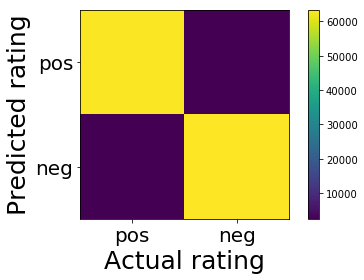

In [67]:
a = confusion_matrix(y_test2, preds2)

plt.imshow(a,  interpolation='nearest')
plt.colorbar()
plt.xlabel('Actual rating')
plt.ylabel('Predicted rating')
plt.xticks((0,1),('pos','neg'), fontsize = 20)
plt.yticks((0,1),('pos','neg'), fontsize = 20)
plt.rc('axes', titlesize=25)

plt.tight_layout()
plt.show()
#plt.savefig('pos_neg_heat_map.png')